<a href="https://colab.research.google.com/github/SyarifulMsth/TaniCerdas/blob/main/notebooks/Jagung_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# === Description ===
> Implementasi Machine Learning Pada Aplikasi Deteksi Penyakit Tanaman Menggunakan Algoritma CNN Dengan Tensorflow

1.   **Object** : Tanaman Jagung
2.   **Class** : Blight, Common rust, dan Healthy
3. **Dataset** : 1500 gambar.
4. **Model Architecture** : DenseNet121

Model ini digunakan untuk mendeteksi hama atau penyakit pada tanaman pertanian, yaitu tanaman Jagung. Dataset yang digunakan bersumber dari Kaggle.com

## Import Library


In [1]:
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing import image
from tensorflow.keras import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import datasets, layers, models, optimizers
from keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D, GlobalAveragePooling2D

import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

## Mount to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
%cd /content/drive/My Drive/Skripsi/Dataset/Jagung
!ls

/content/drive/My Drive/Skripsi/Dataset/Jagung
 best_model.h5	 Blight   Common_Rust  'Corn_Blight (115).JPG'	 Healthy   Late_Blight_1.jpg


## Train, Validation, and Testing Variabel

In [5]:
data_dir = '/content/drive/My Drive/Skripsi/Dataset/Jagung'
print("Folders in Data dir:\t", os.listdir(data_dir))

Folders in Data dir:	 ['Common_Rust', 'Blight', 'Healthy', 'Late_Blight_1.jpg', 'Corn_Blight (115).JPG', 'best_model.h5']


## Exploratory Data Analytics

In [6]:
Blight_dir = os.path.join(data_dir, "Blight")
Common_Rust_dir = os.path.join(data_dir, "Common_Rust")
Healthy_dir = os.path.join(data_dir, "Healthy")

print("The number of Blight in the data \t\t:", len(os.listdir(Blight_dir)))
print("The number of Common Rust in the data \t\t:", len(os.listdir(Common_Rust_dir)))
print("The number of Healthy in the data \t\t:", len(os.listdir(Healthy_dir)))

The number of Blight in the data 		: 500
The number of Common Rust in the data 		: 500
The number of Healthy in the data 		: 500


In [7]:
file_Blight = os.listdir(Blight_dir)
print(file_Blight[:10])
file_Common_Rust = os.listdir(Common_Rust_dir)
print(file_Common_Rust[:10])
file_healthy = os.listdir(Healthy_dir)
print(file_healthy[:10])

['Corn_Blight (111).JPG', 'Corn_Blight (664).JPG', 'Corn_Blight (216).JPG', 'Corn_Blight (267).JPG', 'Corn_Blight (529).JPG', 'Corn_Blight (558).JPG', 'Corn_Blight (277).JPG', 'Corn_Blight (291).JPG', 'Corn_Blight (276).JPG', 'Corn_Blight (183).JPG']
['Corn_Common_Rust (302).JPG', 'Corn_Common_Rust (484).JPG', 'Corn_Common_Rust (503).JPG', 'Corn_Common_Rust (287).JPG', 'Corn_Common_Rust (253).JPG', 'Corn_Common_Rust (309).JPG', 'Corn_Common_Rust (254).JPG', 'Corn_Common_Rust (289).JPG', 'Corn_Common_Rust (263).JPG', 'Corn_Common_Rust (283).JPG']
['Corn_Health (617).JPG', 'Corn_Health (570).jpg', 'Corn_Health (593).jpg', 'Corn_Health (565).jpg', 'Corn_Health (607).jpg', 'Corn_Health (543).jpg', 'Corn_Health (533).jpg', 'Corn_Health (601).jpg', 'Corn_Health (563).jpg', 'Corn_Health (559).jpg']


In [8]:
Blight_imgs = os.listdir(Blight_dir)
Common_Rust_imgs = os.listdir(Common_Rust_dir)
Healthy_imgs = os.listdir(Healthy_dir)

In [9]:
# Method for data visualization sample
def data_visualization_sample(type_diseases_imgs, type_diseases_dir ):
  plt.figure(figsize=(17, 5))
  for i, img_path in enumerate(type_diseases_imgs[:6]):
    sp = plt.subplot(1, 6, i+1)
    img = mpimg.imread(os.path.join(type_diseases_dir, img_path))
    plt.imshow(img)
  return plt.show(block=None)


 Sample Blight images:



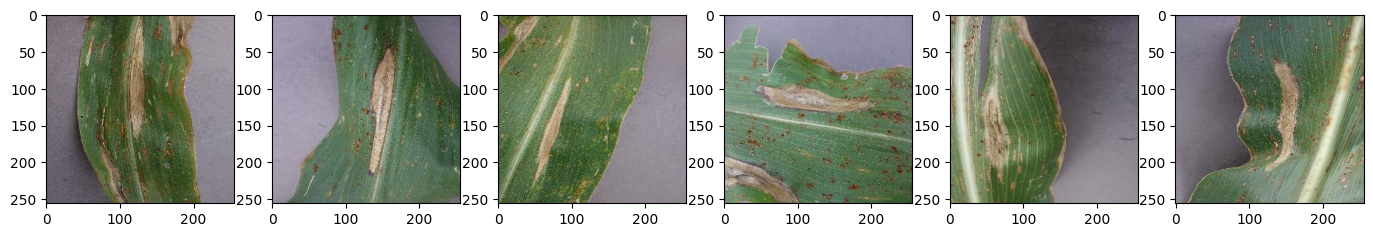

In [10]:
print('\n Sample Blight images:\n')
data_visualization_sample(Blight_imgs,Blight_dir)


 Sample Common Rust images:



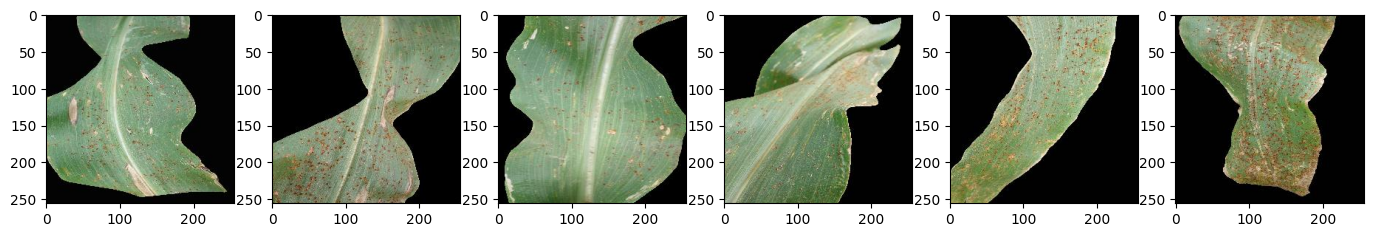

In [11]:
print('\n Sample Common Rust images:\n')
data_visualization_sample(Common_Rust_imgs,Common_Rust_dir)


 Sample Healthy images:



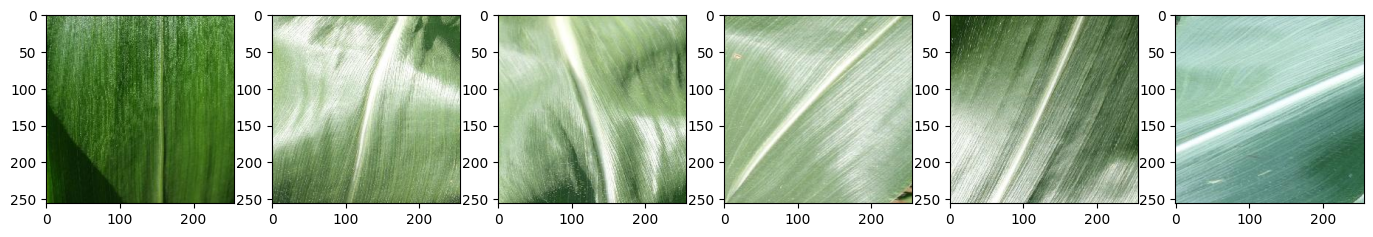

In [12]:
print('\n Sample Healthy images:\n')
data_visualization_sample(Healthy_imgs, Healthy_dir)

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    )

validation_datagen = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.2
    )

In [14]:
train_generator = train_datagen.flow_from_directory(
        data_dir,
        batch_size = 100,
        target_size = (224,224),
        class_mode = 'categorical',
        subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
        data_dir,
        batch_size = 32,
        target_size = (224,224),
        class_mode = 'categorical',
        subset='validation',
        shuffle=False
)

Found 1200 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


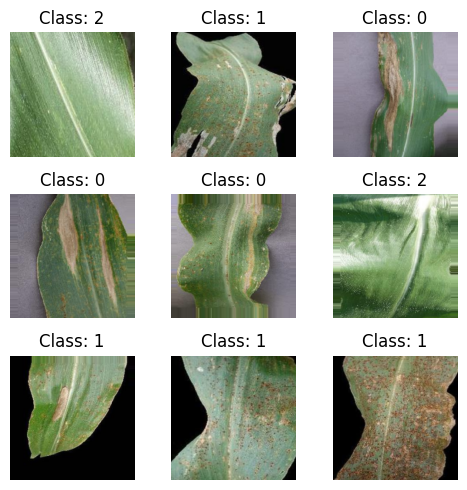

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Display augmented images in a 3x3 grid
def plot_images(images_arr, labels):
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels, axes):
        ax.imshow(img)
        ax.set_title(f'Class: {label}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

augmented_images, labels = next(train_generator)
plot_images(augmented_images[:9], [np.argmax(label) for label in labels[:9]])

In [16]:
train_generator.class_indices

{'Blight': 0, 'Common_Rust': 1, 'Healthy': 2}

In [31]:
labels = []
for label in train_generator.class_indices:
  labels.append(label)
num_labels = len(labels)

print("Labels: {}".format(labels))
print("Num labels: {}".format(num_labels))

Labels: ['Blight', 'Common_Rust', 'Healthy']
Num labels: 3


## Callback

In [18]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15, verbose=1)

# DenseNet121 Model Architecture

In [19]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D, GlobalAveragePooling2D

In [20]:
# Model Functional API
pre_trained_model = DenseNet121(input_shape = (224, 224, 3),
                                include_top = False,
                                weights = 'imagenet')

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

def create_model():
  base_model = pre_trained_model.output
  dropout_layer = Dropout(0.5)(base_model)
  GlobalAveragePooling2DLayer = layers.GlobalAveragePooling2D()(dropout_layer)
  denseLayer = layers.Dense(512, activation='relu')(GlobalAveragePooling2DLayer)
  outputs = Dense(3, activation='softmax')(denseLayer)
  densenet_model = Model(pre_trained_model.input, outputs)

# Compile
  densenet_model.compile(
      loss='categorical_crossentropy',
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
      metrics=['accuracy']
      )
  return densenet_model

densenet_model = create_model()

29084464/29084464 [==============================] - 2s 0us/step


In [21]:
densenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [22]:
densenet_history = densenet_model.fit(train_generator,
                    epochs = 50,
                    validation_data = validation_generator,
                    verbose = 1,
                    callbacks=[callbacks]
                    )

Epoch 1/50
12/12 [==============================] - 484s 40s/step - loss: 0.7615 - accuracy: 0.6692 - val_loss: 0.2837 - val_accuracy: 0.9533
Epoch 2/50
12/12 [==============================] - 16s 1s/step - loss: 0.2087 - accuracy: 0.9608 - val_loss: 0.1014 - val_accuracy: 0.9767
Epoch 3/50
12/12 [==============================] - 16s 1s/step - loss: 0.1085 - accuracy: 0.9783 - val_loss: 0.0645 - val_accuracy: 0.9800
Epoch 4/50
12/12 [==============================] - 16s 1s/step - loss: 0.0843 - accuracy: 0.9833 - val_loss: 0.0520 - val_accuracy: 0.9900
Epoch 5/50
12/12 [==============================] - 16s 1s/step - loss: 0.0651 - accuracy: 0.9867 - val_loss: 0.0419 - val_accuracy: 0.9967
Epoch 6/50
12/12 [==============================] - 16s 1s/step - loss: 0.0575 - accuracy: 0.9892 - val_loss: 0.0401 - val_accuracy: 0.9933
Epoch 7/50
12/12 [==============================] - 16s 1s/step - loss: 0.0564 - accuracy: 0.9858 - val_loss: 0.0332 - val_accuracy: 0.9967
Epoch 8/50
12/12 [

### Model Evaluate

In [23]:
score_train = densenet_model.evaluate(train_generator)
score_valid = densenet_model.evaluate(validation_generator)

print('Accuracy (train): ', score_train[1])
print('Accuracy (test):', score_valid[1])
print('Loss (train): ', score_train[0])
print('Loss (test):', score_valid[0])

10/10 [==============================] - 1s 84ms/step - loss: 0.0123 - accuracy: 1.0000
Accuracy (train):  0.996666669845581
Accuracy (test): 1.0
Loss (train):  0.021691100671887398
Loss (test): 0.012283685617148876


### Plot The Training & Validation Accuracies for Each Epochs

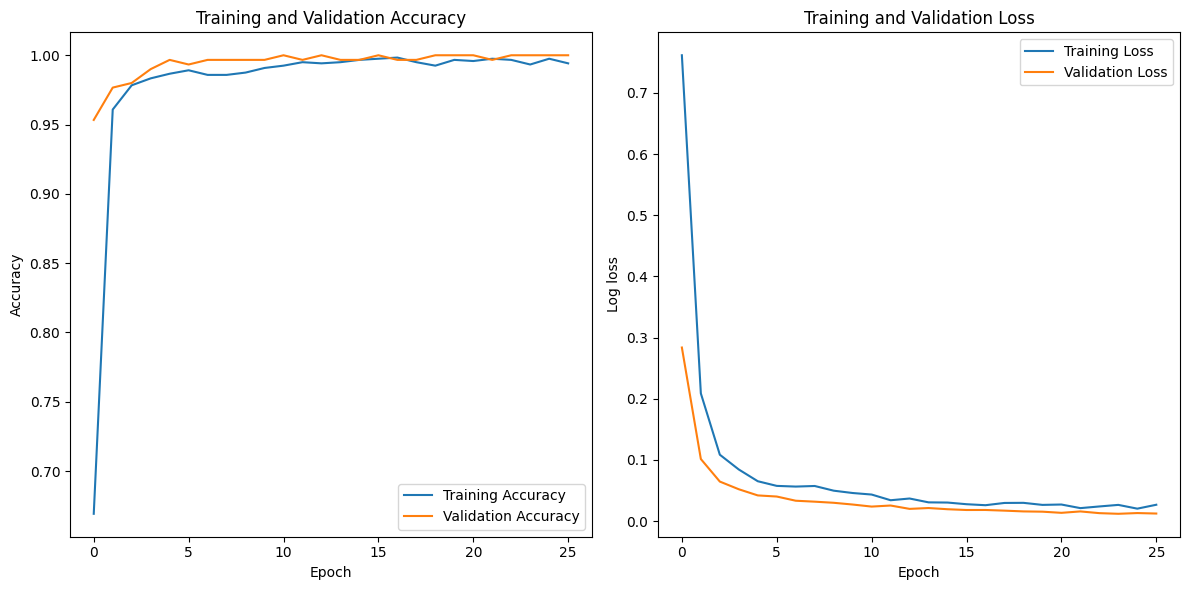

In [24]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(densenet_history.history['accuracy'], label='Training Accuracy')
plt.plot(densenet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(densenet_history.history['loss'], label='Training Loss')
plt.plot(densenet_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Confussion Matrix

<ipython-input-25-a20642aac7ec>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = densenet_model.predict_generator(validation_generator)


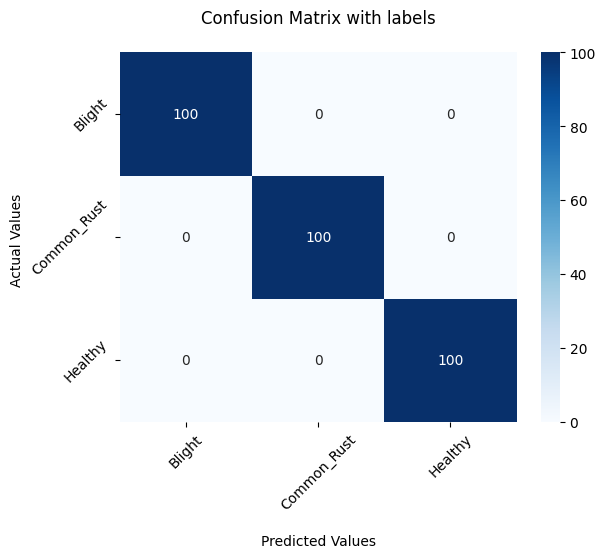

In [25]:
y_test = validation_generator.classes
y_pred = densenet_model.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(labels, rotation=45)
ax.yaxis.set_ticklabels(labels, rotation=45)

plt.show()

### Classification Report

In [26]:
print(classification_report(y_test, y_pred))
print("Labels: ",train_generator.class_indices)
print()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

Labels:  {'Blight': 0, 'Common_Rust': 1, 'Healthy': 2}



## Save Model to h.5 for deployment

In [33]:
from pathlib import Path

load_model_dir = "/content/drive/My Drive/Skripsi/Load_models/Jagung/"

#python program to check if a path exists
#if it doesn’t exist we create one
import os
if not os.path.exists(load_model_dir):
   os.makedirs(load_model_dir)

In [34]:
densenet_model.save(os.path.join(load_model_dir, 'Jagung_models.h5'))

In [35]:
saved_model_path = os.path.join(load_model_dir, 'Jagung_models.h5')
if os.path.exists(saved_model_path):
    print('Model berhasil disimpan di Google Drive.')
else:
    print('Model gagal disimpan di Google Drive.')

Model berhasil disimpan di Google Drive.


## Predict Model with User Image Input

Saving Corn_Common_Rust (96).JPG to Corn_Common_Rust (96).JPG
1/1 [==============================] - 3s 3s/step

Probablity:
Blight : 0.02%
Common Rust : 99.98%
Healthy : 0.00%

Predict:
Common Rust


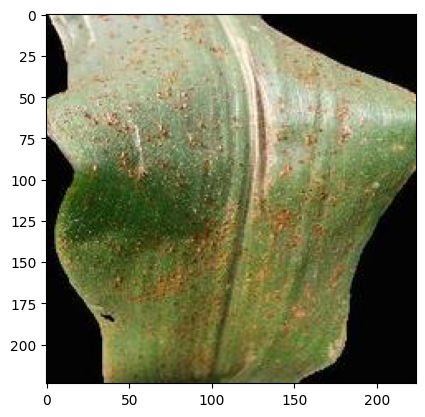

In [32]:
import keras.utils as image
from google.colab import files

# get user image input
labels = ['Blight', 'Common Rust', 'Healthy']

uploaded = files.upload()

for path in uploaded.keys():
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  images /= 255

  classes = densenet_model.predict(images, batch_size=32)
  predicted_class_indices=np.argmax(classes)

print("\nProbablity:")
for idx, val in enumerate(labels):
  print("{} : {:.2f}%".format(val, classes[0][idx] * 100))

print("\nPredict:")
if predicted_class_indices == 0:
  print('Blight')
elif predicted_class_indices == 1:
  print('Common Rust')
elif predicted_class_indices == 2:
  print('Healthy')
else:
  print('Unknown!')